In [1]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
#import celerite
#from celerite import terms

### 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

Metadata

In [2]:
import pandas as pd

filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [3]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

Download light curve from MAST

In [4]:
flc = lightkurve.search_lightcurve("EPIC 246301900", cadence="long", campaign=12, mission="K2")
print(flc)

SearchResult containing 3 data products.

 #     mission     year  author exptime  target_name  distance
                                   s                   arcsec 
--- -------------- ---- ------- ------- ------------- --------
  0 K2 Campaign 12 2016      K2    1800 ktwo246301900      0.0
  1 K2 Campaign 12 2016 EVEREST    1800 ktwo246301900      0.0
  2 K2 Campaign 12 2016   K2SFF    1800 ktwo246301900      0.0


In [5]:
download = flc[2].download()

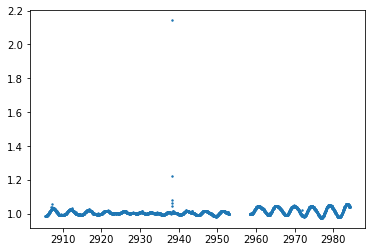

In [6]:
plt.scatter(download.time.value, download.flux.value, s=2)
plt.show()

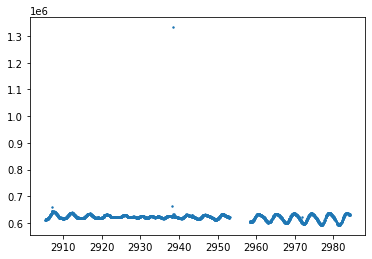

In [7]:
plt.scatter(df.TIME, df.PDCSAP_FLUX, s=2)
plt.show()

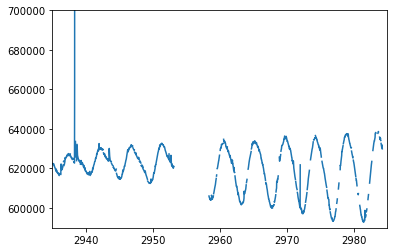

In [8]:
# examine the gap
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2935,2985])
plt.ylim([590000,700000])
plt.show()

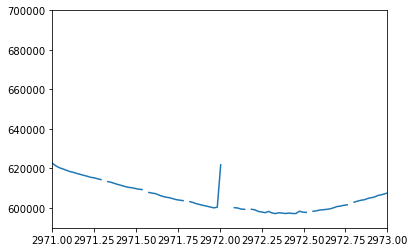

3256    601289.4375
3257    600915.5625
3258    600486.1250
3259    600089.1250
3260    600415.0000
3261    621832.1875
3262            NaN
3263            NaN
3264            NaN
3265    600196.0000
Name: PDCSAP_FLUX, dtype: float32


In [9]:
# examine spike/possible flare shortly after 2970 BJD
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2971,2973])
plt.ylim([590000,700000])
plt.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)

### 2) GP Modeling

3255


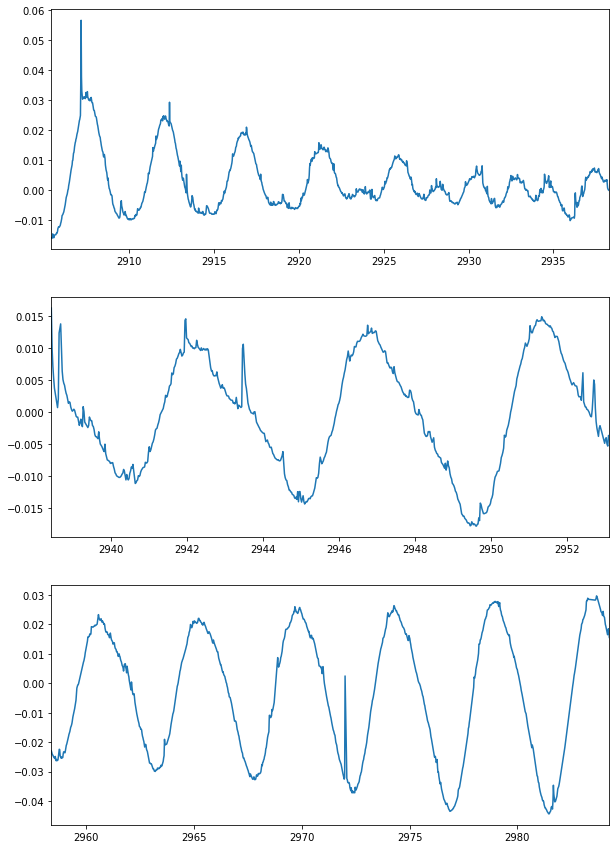

In [10]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

Pre-super-flare

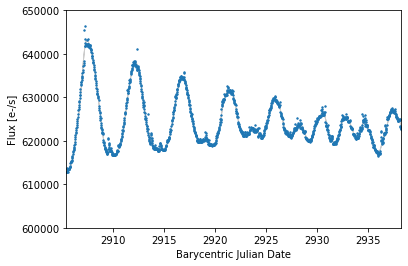

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612618.92896777 612804.18461946 612963.9255443  ... 623070.7172213
 622716.37750874 622305.10046592]


In [11]:
lhs_pre = min(pre.TIME)
rhs_pre = max(pre.TIME)
xobs_pre = np.array(pre["TIME"])
yobs_pre = np.array(pre["PDCSAP_FLUX"])
eobs_pre = np.array(pre["PDCSAP_FLUX_ERR"])

kernel_pre = np.var(yobs_pre) * ExpSquaredKernel(0.5)
gp_pre = george.GP(kernel_pre)
gp_pre.compute(xobs_pre, eobs_pre)

pred_pre, pred_var_pre = gp_pre.predict(yobs_pre, xobs_pre, return_var=True)

plt.fill_between(xobs_pre, pred_pre - np.sqrt(pred_var_pre), pred_pre + np.sqrt(pred_var_pre),
                color="k", alpha=0.2)
#plt.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#plt.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
plt.xlim(lhs_pre, rhs_pre)
#plt.xlim(lhs,2910)
plt.ylim(600000,650000)
plt.xlabel(r'Barycentric Julian Date')
plt.ylabel(r'Flux [e-/s]')
plt.scatter(xobs_pre, yobs_pre, s=2)
plt.show()

print(yobs_pre)
print(pred_pre)

Same for post and postgap

In [12]:
def alias(df, normalized_flag):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    
    lhs = min(df.TIME)
    rhs = max(df.TIME)
    xobs = np.array(df["TIME"])
    yobs = np.array(df["PDCSAP_FLUX"])
    eobs = np.array(df["PDCSAP_FLUX_ERR"])
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.5)
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        pred, pred_var = gp.predict(yobs, xobs, return_var=True)
        
        return pred, pred_var
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        
        return pred, pred_var

pred_pre, pred_var_pre = alias(pre, normalized_flag=True)
pred_post, pred_var_post = alias(post, normalized_flag=True)
pred_postgap, pred_var_postgap = alias(postgap, normalized_flag=True)


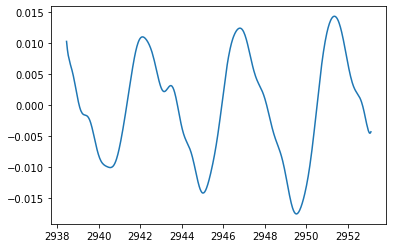

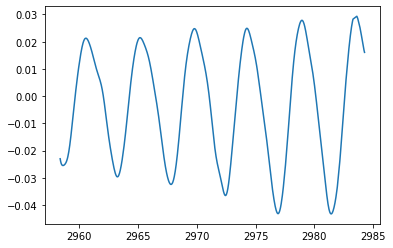

In [13]:
plt.plot(post.TIME, pred_post)
plt.show()

plt.plot(postgap.TIME, pred_postgap)
plt.show()

### 3) Inject flares

Pieces taken from Ekaterina Ilin's Altaipony: https://github.com/ekaterinailin/AltaiPony/blob/037bd76c8ed09ed6340cf2105d1e83bc302168eb/altaipony/flarelc.py

In [14]:
from altaipony.fakeflares import generate_fake_flare_distribution, mod_random, aflare

def inject_fakes(error, flux, df, num_flares):
    
    def _equivalent_duration(time, flux):
            '''
            Compute the Equivalent Duration of a fake flare.
            This is the area under the flare, in relative flux units.
            Parameters:
            -------------
            time : numpy array
                units of DAYS
            flux : numpy array
                relative flux units
            Return:
            ------------
            p : float
                equivalent duration of a single event in units of seconds
            '''
            x = time * 60.0 * 60.0 * 24.0
            integral = np.sum(np.diff(x) * flux[:-1])
            return integral
        
    # Init arrays for the synthetic flare parameters
    nfake = num_flares # 20 flares per time chunk for a total of 60 fake flares
    t0_fake = np.zeros(nfake, dtype='float') # peak times
    ed_fake = np.zeros(nfake, dtype='float') # ED
    #dur_fake = np.zeros(nfake, dtype='float') # duration
    #ampl_fake = np.zeros(nfake, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Pick flux, time, and flux error arrays 
    error = error # pred_var_pre
    flux = flux # pred_pre
    time = np.array(df.TIME)
    #print(np.array(time))
    #print(download.time.value)
    
    # generate the time constraints for the flares you want to inject
    mintime, maxtime = np.min(time), np.max(time)
    dtime = maxtime - mintime

    # generate a distribution of durations and amplitudes
    d = False
    seed = 23 # mashed keyboard idk
    #default: ampl=[1e-4, 5], dur=[0.005, 0.012]
    distribution  = generate_fake_flare_distribution(nfake, d=d,
                                            seed=seed)
    dur_fake = distribution[0]
    ampl_fake = distribution[1]    
    
    for k in range(nfake):
        # add the peak time to the list and note the index
        t0 = (mod_random(1, d=d) * dtime + mintime)[0]
        t0_fake[k] = t0
    
        # generate the flare flux from the Davenport 2014 model
        fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])

        # calculate the injected ED
        ed_fake[k] = _equivalent_duration(time, fl_flux)
        
        # inject flare into light curve by adding the flare flux
        flux = flux + fl_flux
        #fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
        #                            fl_flux * fake_lc.it_med[le:ri].value)
    
    return dur_fake, ampl_fake, t0_fake, ed_fake, flux

dur_fake_pre, ampl_fake_pre, t0_fake_pre, ed_fake_pre, flux_pre = inject_fakes(np.sqrt(pred_var_pre), 
                                                                    pred_pre, pre, num_flares=20)
dur_fake_post, ampl_fake_post, t0_fake_post, ed_fake_post, flux_post = inject_fakes(np.sqrt(pred_var_post), 
                                                                    pred_post, post, num_flares=10)
dur_fake_postgap, ampl_fake_postgap, t0_fake_postgap, ed_fake_postgap, flux_postgap = inject_fakes(np.sqrt(pred_var_postgap), 
                                                                    pred_postgap, postgap, num_flares=20)

In [15]:
print(dur_fake_pre)
print(ampl_fake_pre)
print(t0_fake_pre)
print(ed_fake_pre)
print(flux_pre)

[0.00741318 0.00990739 0.01000019 0.00997607 0.01181988 0.01110234
 0.01136439 0.00932639 0.00785592 0.00609577 0.0077229  0.00999328
 0.00663561 0.00782543 0.00502654 0.00579163 0.01047511 0.01012939
 0.00767217 0.00984906]
[3.15208876 1.13476975 3.19929142 4.19419229 2.80472955 4.08441423
 0.20732486 0.57003138 4.8811935  4.72892868 3.2691512  3.36494845
 0.17689298 0.16180546 2.90674867 0.88562453 2.86052965 2.56659764
 0.40253295 4.44707505]
[2915.37514406 2915.73279287 2928.02572165 2928.15130335 2937.47555638
 2934.755753   2926.90787646 2918.90024136 2932.56655523 2915.92650103
 2911.50366522 2926.50047636 2935.02705927 2937.92622513 2936.8549117
 2933.42715462 2914.55843164 2937.82902748 2928.74051337 2912.72676328]
[ 769.81836112 1169.21560612 1526.36538273 2599.85805296 5635.30271614
 5338.22535316  206.62598506  604.62121989 2894.49645274  825.30912864
 2841.72518545 3533.50309753   29.73429997  184.30145552  745.61905212
  596.9792336   442.4019614   948.59370182  131.39431

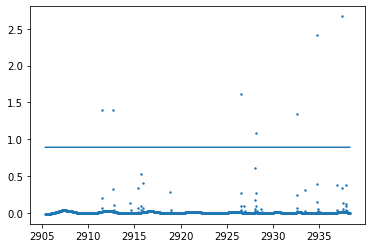

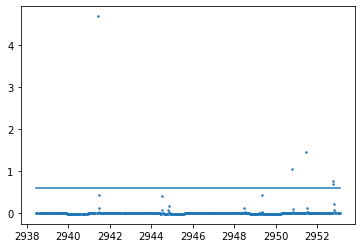

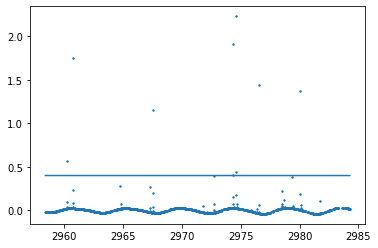

In [16]:
### did I do it?
plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, np.ones(len(pre))*np.median(flux_pre)+7*np.std(flux_pre))
#plt.xlim(2908, 2911)
plt.show()

plt.scatter(post.TIME, flux_post, s=2)
plt.plot(post.TIME, np.ones(len(post))*np.median(flux_post)+3*np.std(flux_post))
plt.show()

plt.scatter(postgap.TIME, flux_postgap, s=2)
plt.plot(postgap.TIME, np.ones(len(postgap))*np.median(flux_postgap)+3*np.std(flux_postgap))
plt.show()
### yes I did!

### 4) Recover fake flares

In [17]:
print(np.abs(flux_pre))
print(np.abs(flux_pre) / np.sqrt(pred_var_pre))
print(np.abs(flux_pre) / pred_var_pre)
print(np.median(flux_pre))
print(np.median(flux_pre)+3*np.std(flux_pre))

[1.60955132e-02 1.59712913e-02 1.58403865e-02 ... 3.84011265e-04
 5.80743885e-05 5.43548919e-04]
[1.11307572e-03 1.43298206e-03 1.76217826e-03 ... 4.12645778e-05
 5.05809464e-06 3.66782122e-05]
[7.69740953e-05 1.28570543e-04 1.96035129e-04 ... 4.43415476e-06
 4.40543966e-07 2.47501412e-06]
0.00033518081963279656
0.38156995476075106


In [18]:
flux = flux_pre
var = pred_var_pre
#var = pre.PDCSAP_FLUX_ERR
T0 = flux # excursion should be positive #"N0"
T1 = np.abs(flux) / np.std(flux) #N1
T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
print("T1: ", T1)
print("T2: ", T2)
minsep = 3
N1 = 7
N2 = 3
N3 = 1
istart = np.array([], dtype='int')
istop = np.array([], dtype='int')

pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
print("pass thresholds: ", pass_thresholds)

#array of indices where thresholds are exceeded:
is_pass_thresholds = np.zeros_like(flux)
is_pass_thresholds[pass_thresholds] = 1

# test based on consecutive points
reverse_counts = np.zeros_like(flux, dtype='int')
for k in range(2, len(flux)):
    reverse_counts[-k] = (is_pass_thresholds[-k]
                            * (reverse_counts[-(k-1)]
                            + is_pass_thresholds[-k]))

# find flare start where values in reverse_counts switch from 0 to >=N3
istart_i = np.where((reverse_counts[1:] >= N3) &
                    (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

# use the value of reverse_counts to determine how many points away stop is
istop_i = istart_i + (reverse_counts[istart_i])

# Create boolean flare mask
isflare = np.zeros_like(flux, dtype='bool')

for (l,r) in list(zip(istart_i, istop_i)):
    isflare[l:r+1] = True
    
print("is flare? ", isflare)

### 

# now pick out final flare candidate indices
candidates = np.where( isflare > 0)[0]
print("candidates: ", candidates)
if (len(candidates) < 1): # no candidates = no indices
    istart_gap = np.array([])
    istop_gap = np.array([])
else:
    # find start and stop index, combine neighboring candidates
    # in to same events
    separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
    istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
    istop_gap = candidates[ np.append(separated_candidates,
                            [len(candidates) - 1]) ]

print(istart_gap)
print(istop_gap)
#stitch indices back into the original light curve
#istart = np.array(np.append(istart, istart_gap + le), dtype='int')
#istop = np.array(np.append(istop, istop_gap + le), dtype='int')

print(len(istart_gap))

T1:  [0.12665828 0.12568075 0.12465064 ... 0.00302185 0.000457   0.00427728]
T2:  [113.9179076   87.83142227  70.86133227 ...  73.22803576  90.35010014
 116.62056851]
pass thresholds:  (array([ 276,  334,  974, 1050, 1250, 1348, 1473]),)
is flare?  [False False False ... False False False]
candidates:  [ 276  277  334  335  974  975 1050 1051 1250 1251 1348 1349 1473 1474]
[ 276  334  974 1050 1250 1348 1473]
[ 277  335  975 1051 1251 1349 1474]
7


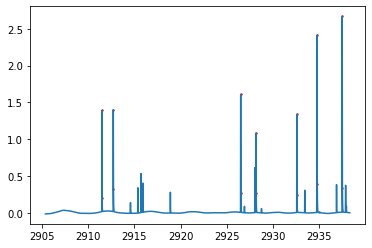

In [51]:
#for xc in pre.TIME[istart_gap]:
#    plt.axvline(x=xc, c='r')
#for xc in t0_fake_pre:
#    plt.axvline(x=xc, c='r', linestyle='--')
#plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, flux_pre)
#plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
plt.scatter(np.array(pre.TIME)[candidates], flux_pre[candidates], c='r', s=2)
#plt.xlim(2932, 2933)
#plt.xlim(2911, 2913)
plt.show()

### 5) Evaluate recovery

Compare istart_gaps and t0s to calculate TPs, FPs, and FNs. 

In [26]:
print(istart_gap)
print(np.array(pre.TIME)[istart_gap])

[ 276  334  974 1050 1250 1348 1473]
[2911.50689244 2912.73281907 2926.50394478 2928.15891895 2932.57217224
 2934.75836177 2937.47577041]


In [27]:
t0_fake_pre

array([2915.37514406, 2915.73279287, 2928.02572165, 2928.15130335,
       2937.47555638, 2934.755753  , 2926.90787646, 2918.90024136,
       2932.56655523, 2915.92650103, 2911.50366522, 2926.50047636,
       2935.02705927, 2937.92622513, 2936.8549117 , 2933.42715462,
       2914.55843164, 2937.82902748, 2928.74051337, 2912.72676328])

In [56]:
pred_flares_pre = pd.DataFrame({'istart': np.array(pre.TIME)[istart_gap], 
                                'istop': np.array(pre.TIME)[istop_gap],
                               'gap': np.array(pre.TIME)[istop_gap]-np.array(pre.TIME)[istart_gap]})
print(pred_flares_pre)

tps = 0
for i in t0_fake_pre:
    # exploit the shape of the flare for some breathing room: if t0 is within max(istop-istart) of istart, then it's a TP
    if (np.abs(i - pred_flares_pre['istart']) < np.max(pred_flares_pre['gap'])).any():
        tps += 1
fps = len(istart_gap) - tps      
fns = len(t0_fake_pre) - tps
print("TPs: ", tps)
print("FPs: ", fps)
print("FNs: ", fns)

        istart        istop       gap
0  2911.506892  2911.527325  0.020432
1  2912.732819  2912.753251  0.020432
2  2926.503945  2926.524377  0.020432
3  2928.158919  2928.179351  0.020432
4  2932.572172  2932.592604  0.020432
5  2934.758362  2934.778793  0.020432
6  2937.475770  2937.496202  0.020432
TPs:  7
FPs:  0
FNs:  13


Functionalize everything

In [57]:
def recover_flares(flux, var, N1, N2, N3, minsep):
    """
    Params:
    - flux: GP-predicted flux with flares injected
    - var: variance from GP-prediction of smoothed (pre-flare-injection) light curve
    - N1: int or float (default is 3)
        How many times above sigma is required.
    - N2: int or float (Default is 3)
        How many times above sigma and detrended_flux_err is required
    - N3: int or float (Default is 2)
        The number of consecutive points required to flag as a flare.
    - minsep: 1 or int
        minimum distance between two candidate start times in datapoints
    Returns:
    - candidates: flare points
    - istart_gap: flare start indices
    - istop_gap: flare stop indices
    """

    #var = pre.PDCSAP_FLUX_ERR
    T0 = flux # excursion should be positive #"N0"
    T1 = np.abs(flux) / np.std(flux) #N1
    T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
    minsep = 3
    istart = np.array([], dtype='int')
    istop = np.array([], dtype='int')

    pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))

    #array of indices where thresholds are exceeded:
    is_pass_thresholds = np.zeros_like(flux)
    is_pass_thresholds[pass_thresholds] = 1

    # test based on consecutive points
    reverse_counts = np.zeros_like(flux, dtype='int')
    for k in range(2, len(flux)):
        reverse_counts[-k] = (is_pass_thresholds[-k]
                                * (reverse_counts[-(k-1)]
                                + is_pass_thresholds[-k]))

    # find flare start where values in reverse_counts switch from 0 to >=N3
    istart_i = np.where((reverse_counts[1:] >= N3) &
                        (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

    # use the value of reverse_counts to determine how many points away stop is
    istop_i = istart_i + (reverse_counts[istart_i])

    # Create boolean flare mask
    isflare = np.zeros_like(flux, dtype='bool')

    for (l,r) in list(zip(istart_i, istop_i)):
        isflare[l:r+1] = True

    # now pick out final flare candidate indices
    candidates = np.where( isflare > 0)[0]
    print("candidates: ", candidates)
    if (len(candidates) < 1): # no candidates = no indices
        istart_gap = np.array([])
        istop_gap = np.array([])
    else:
        # find start and stop index, combine neighboring candidates
        # in to same events
        separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
        istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
        istop_gap = candidates[ np.append(separated_candidates,
                                [len(candidates) - 1]) ]

    print(istart_gap)
    print(istop_gap)
    #stitch indices back into the original light curve
    #istart = np.array(np.append(istart, istart_gap + le), dtype='int')
    #istop = np.array(np.append(istop, istop_gap + le), dtype='int')

    print(len(istart_gap))
    
recover_flares(flux_pre, pred_var_pre, N1=7, N2=3, N3=1, minsep=3)